# Dog Heart Vertebral Heart Size (VHS) Point Detection

This project aims to detect key points on dog heart images and compute the Vertebral Heart Size (VHS). The code is divided into several sections, including data preparation, model definition, training, validation, and testing.


In [1]:
# Import necessary libraries
import os
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from scipy.io import loadmat
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt


## Dataset Class

Define a custom dataset class to load images and their corresponding key points and VHS values.


In [2]:
# Dataset class
class DogHeartDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        points_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        if self.transforms is not None:
            img = self.transforms(img)

        h_new, w_new = img.shape[1], img.shape[2]
        mat = loadmat(points_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:, 0] = w_new / w * six_points[:, 0]
        six_points[:, 1] = h_new / h * six_points[:, 1]
        six_points = torch.reshape(six_points, (-1,)) / h_new  # Normalize the points
        VHS = mat['VHS'].astype(float)
        VHS = torch.as_tensor(VHS, dtype=torch.float32)

        return img, six_points, VHS

    def __len__(self):
        return len(self.imgs)


## Transform Function

Define a function to apply image transformations.


In [3]:
# Transform function
def get_transform(resized_image_size):
    transforms = [
        T.ToTensor(),
        T.Resize(size=(resized_image_size, resized_image_size)),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
    return T.Compose(transforms)


## Compute VHS Value

Define a function to compute the VHS value from the detected points.


In [4]:
# Compute VHS value
def compute_vhs(points):
    if not isinstance(points, torch.Tensor):
        points = torch.tensor(points)
    A = torch.sqrt((points[0] - points[2]) ** 2 + (points[1] - points[3]) ** 2)
    B = torch.sqrt((points[2] - points[4]) ** 2 + (points[3] - points[5]) ** 2)
    C = torch.sqrt((points[4] - points[0]) ** 2 + (points[5] - points[1]) ** 2)
    VHS = 6 * (A + B) / C
    return VHS


## Model Definition

Define a custom model for key point detection using a pre-trained ResNet50 as the backbone.


In [5]:
# Define the custom model for keypoint detection
class KeypointDetectionModel(nn.Module):
    def __init__(self, num_keypoints):
        super(KeypointDetectionModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        self.conv1 = nn.Conv2d(2048, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(512, num_keypoints * 2, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.backbone(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x


## Prepare Data Loaders

Create data loaders for training and validation datasets.


In [6]:
# Parameters
resized_image_size = 512
batch_size = 4
num_keypoints = 6

# Create dataset and dataloader
train_dataset = DogHeartDataset('./Dog_data/Train', get_transform(resized_image_size))
val_dataset = DogHeartDataset('./Dog_data/Valid', get_transform(resized_image_size))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## Model Initialization And Training Loop

Instantiate the model, define the optimizer, and set training parameters.


In [7]:
# Instantiate the model
model = KeypointDetectionModel(num_keypoints)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Training parameters
num_epochs = 25  # Slightly higher to allow more training time
learning_rate = 0.01  # Slightly higher initial learning rate

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Implement early stopping
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets, vhs in train_loader:
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(images)
        loss = nn.MSELoss()(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, targets, vhs in val_loader:
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(images)
            loss = nn.MSELoss()(outputs, targets)
            val_loss += loss.item()

            for i in range(len(images)):
                predicted_points = outputs[i].cpu().numpy()
                ground_truth_points = targets[i].cpu().numpy()
                predicted_vhs = compute_vhs(predicted_points)
                ground_truth_vhs = compute_vhs(ground_truth_points)
                if abs(predicted_vhs - ground_truth_vhs) / ground_truth_vhs < 0.15:  # within 15% of ground truth
                    correct_predictions += 1
                total_predictions += 1

    val_losses.append(val_loss / len(val_loader))
    accuracy = (correct_predictions / total_predictions) * 100
    accuracies.append(accuracy)

    # Print loss and accuracy
    print(f'Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%')

    # Early stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

    # Step the learning rate scheduler
    lr_scheduler.step()

print("Training complete")

# Save the model
model_save_path = 'trained_model_bharat.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


/anaconda/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Training Loss: 0.0081, Validation Loss: 0.0047, Accuracy: 54.50%
Epoch 2, Training Loss: 0.0032, Validation Loss: 0.0019, Accuracy: 53.50%
Epoch 3, Training Loss: 0.0020, Validation Loss: 0.0016, Accuracy: 69.00%
Epoch 4, Training Loss: 0.0019, Validation Loss: 0.0016, Accuracy: 70.50%
Epoch 5, Training Loss: 0.0016, Validation Loss: 0.0015, Accuracy: 75.50%
Epoch 6, Training Loss: 0.0015, Validation Loss: 0.0013, Accuracy: 73.50%
Epoch 7, Training Loss: 0.0014, Validation Loss: 0.0012, Accuracy: 75.50%
Epoch 8, Training Loss: 0.0014, Validation Loss: 0.0012, Accuracy: 77.50%
Epoch 9, Training Loss: 0.0013, Validation Loss: 0.0012, Accuracy: 68.50%
Epoch 10, Training Loss: 0.0013, Validation Loss: 0.0012, Accuracy: 76.50%
Epoch 11, Training Loss: 0.0013, Validation Loss: 0.0012, Accuracy: 78.50%
Epoch 12, Training Loss: 0.0013, Validation Loss: 0.0012, Accuracy: 77.50%
Epoch 13, Training Loss: 0.0013, Validation Loss: 0.0012, Accuracy: 76.00%
Epoch 14, Training Loss: 0.0013, V

## Plot Training and Validation Loss

Plot the training and validation loss over epochs.


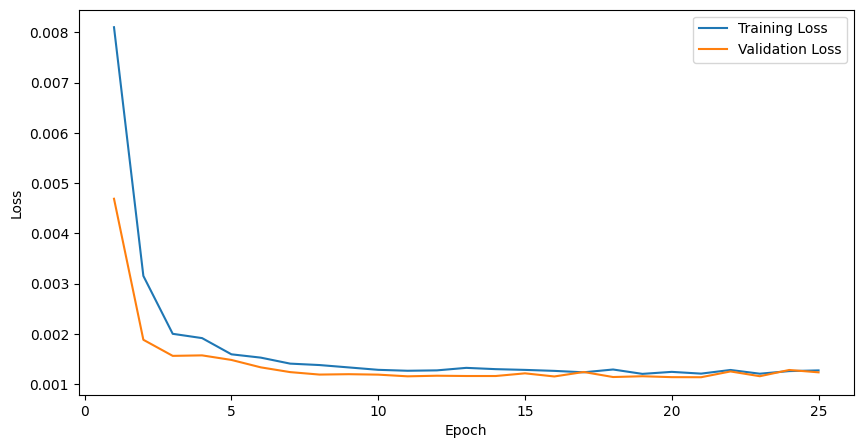

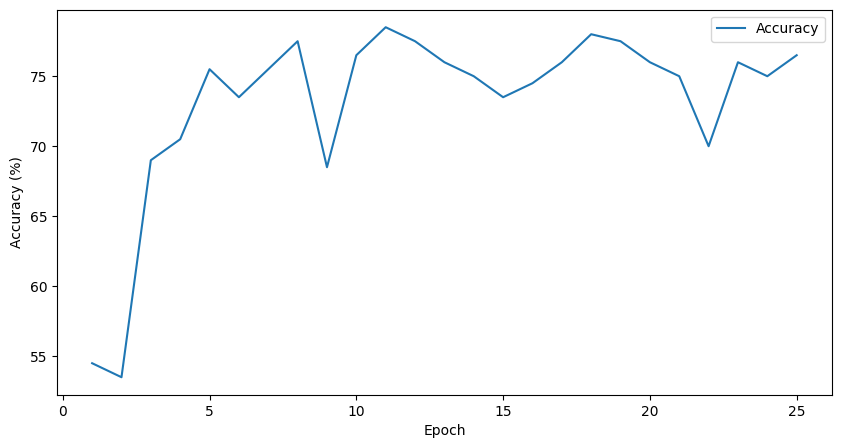

In [8]:
# Plot training loss, validation loss, and accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


## Evaluate and Compare Predictions

Load the validation dataset and compare model predictions with ground truth for specific images.


In [9]:
# Define the function to plot and compare predictions
def plot_comparison(img, predicted_points, ground_truth_points, predicted_vhs, ground_truth_vhs, img_name):
    plt.figure(figsize=(10, 5))
    img_np = img.permute(1, 2, 0).cpu().numpy()

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title(f'Original Image: {img_name}')

    # Plot image with predicted points
    plt.subplot(1, 2, 2)
    plt.imshow(img_np)
    plt.scatter(predicted_points[::2] * img_np.shape[1], predicted_points[1::2] * img_np.shape[0], c='r', marker='x', label='Predicted Points')
    plt.scatter(ground_truth_points[::2] * img_np.shape[1], ground_truth_points[1::2] * img_np.shape[0], c='g', marker='o', label='Ground Truth Points')
    plt.title(f'Predicted VHS: {predicted_vhs:.2f}, Ground Truth VHS: {ground_truth_vhs:.2f}')
    plt.legend()
    plt.show()

# Evaluate the model and show comparison for specific images
model.eval()
image_names_to_compare = ['1420.png', '1479.png', '1530.png']
results = []

with torch.no_grad():
    for images, targets, vhs in val_loader:
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(images)

        for i in range(len(images)):
            img_name = val_dataset.imgs[i]
            if img_name in image_names_to_compare:
                img = images[i]
                predicted_points = outputs[i].cpu().numpy()
                ground_truth_points = targets[i].cpu().numpy()
                predicted_vhs = compute_vhs(predicted_points)
                ground_truth_vhs = compute_vhs(ground_truth_points)
                results.append((img, predicted_points, ground_truth_points, predicted_vhs, ground_truth_vhs, img_name))

# Plot the results for the specified images
for img, predicted_points, ground_truth_points, predicted_vhs, ground_truth_vhs, img_name in results:
    plot_comparison(img, predicted_points, ground_truth_points, predicted_vhs, ground_truth_vhs, img_name)


## Predict on Test Data

Load the test dataset and make predictions.


In [10]:
# Function to load test dataset
def load_test_dataset(test_images_path, transform):
    test_imgs = list(sorted(os.listdir(test_images_path)))
    test_data = []
    for img_name in test_imgs:
        img_path = os.path.join(test_images_path, img_name)
        img = Image.open(img_path).convert("RGB")
        if transform is not None:
            img = transform(img)
        test_data.append((img, img_name))
    return test_data

# Load test dataset
test_images_path = './Dog_data/Images'
test_data = load_test_dataset(test_images_path, get_transform(resized_image_size))

# Predict points on test images
test_results = []

model.eval()
with torch.no_grad():
    for img, img_name in test_data:
        img = img.to(device)

        # Forward pass
        output = model(img.unsqueeze(0))
        predicted_points = output[0].cpu().numpy()

        test_results.append((img.cpu(), predicted_points, img_name))

print(f"Prediction on test data completed. {len(test_results)} results obtained.")


Prediction on test data completed. 400 results obtained.


## Plot Predictions on Test Data

Visualize the predicted key points on test images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6373732].


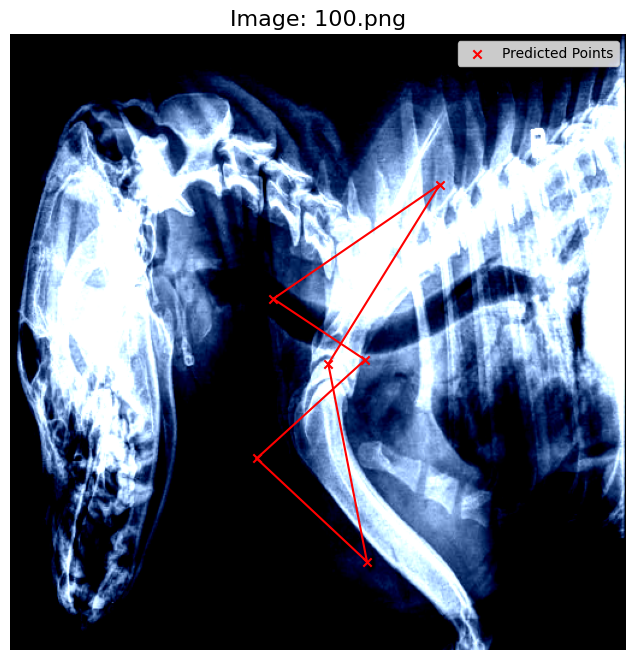

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4408271].


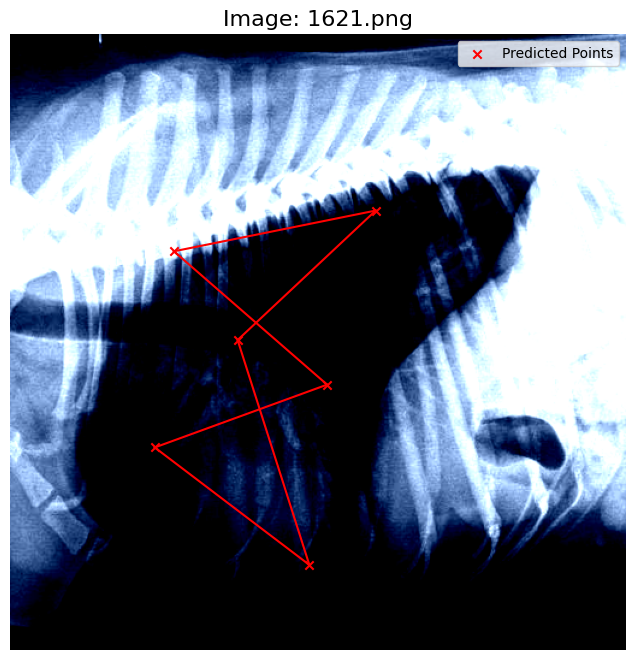

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7035888..2.10395].


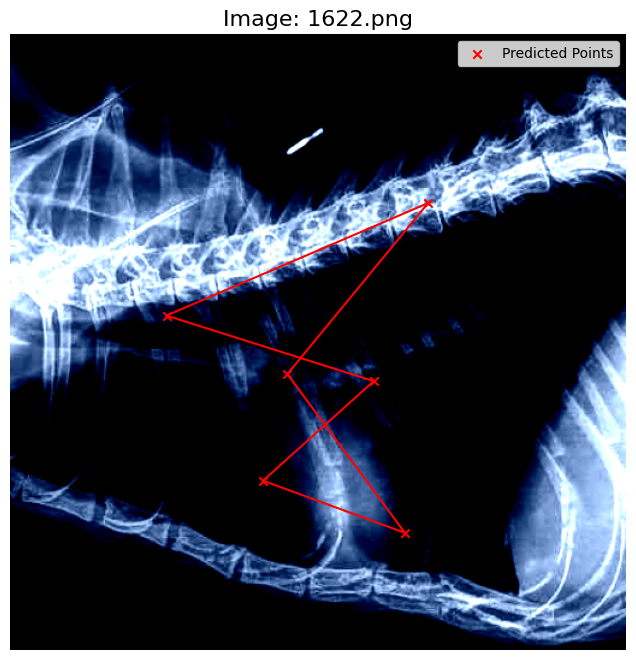

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1170008..2.3955488].


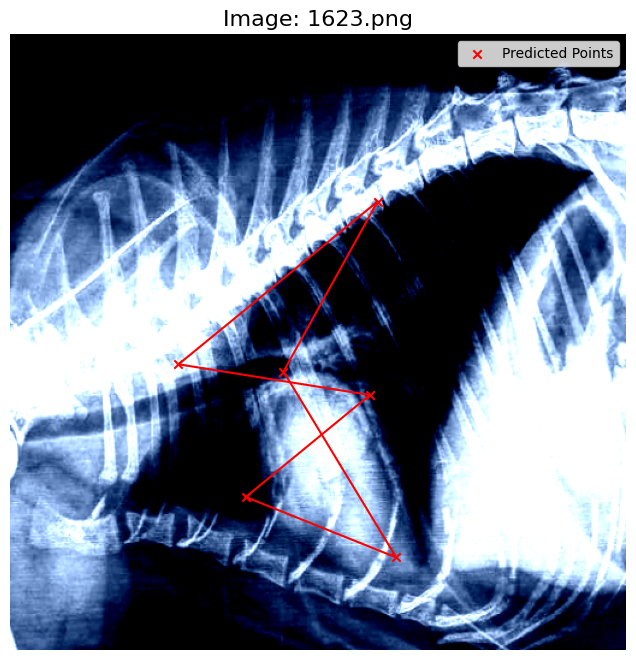

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


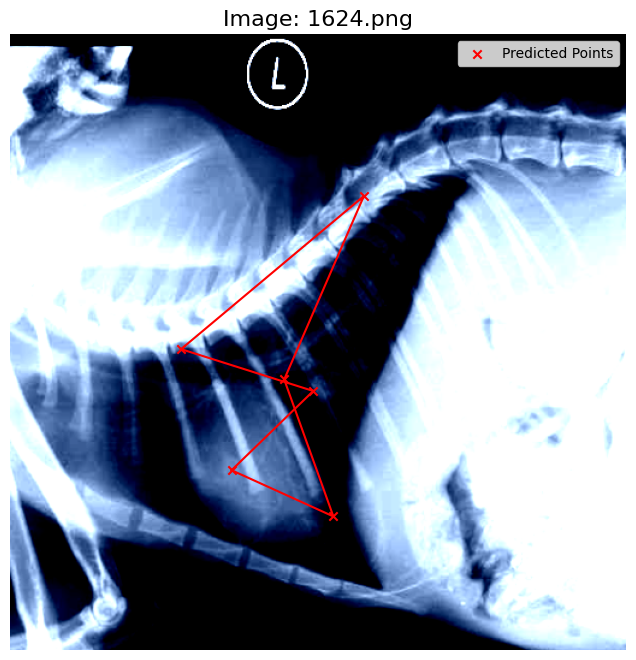

In [11]:
# Function to plot predictions with lines connecting the predicted points
def plot_predictions(img, predicted_points, img_name):
    plt.figure(figsize=(8, 8))
    img_np = img.permute(1, 2, 0).cpu().numpy()

    plt.imshow(img_np)
    
    # Plot predicted points
    x_points = predicted_points[::2] * img_np.shape[1]
    y_points = predicted_points[1::2] * img_np.shape[0]
    
    plt.scatter(x_points, y_points, c='r', marker='x', label='Predicted Points')
    
    # Draw lines connecting the points
    for i in range(len(x_points) - 1):
        plt.plot([x_points[i], x_points[i + 1]], [y_points[i], y_points[i + 1]], 'r-', linewidth=1.5)
    plt.plot([x_points[-1], x_points[0]], [y_points[-1], y_points[0]], 'r-', linewidth=1.5)  # Connect the last point to the first

    plt.title(f'Image: {img_name}', fontsize=16)
    plt.axis('off')
    plt.legend()
    plt.show()

# Plot results for a subset of test images
for i in range(min(5, len(test_results))):
    img, predicted_points, img_name = test_results[i]
    plot_predictions(img, predicted_points, img_name)


## Compare Predictions on Specific Images

Compare the predicted and ground truth points on specific images from the validation set.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1131496..2.2074697].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1131496..2.2074697].


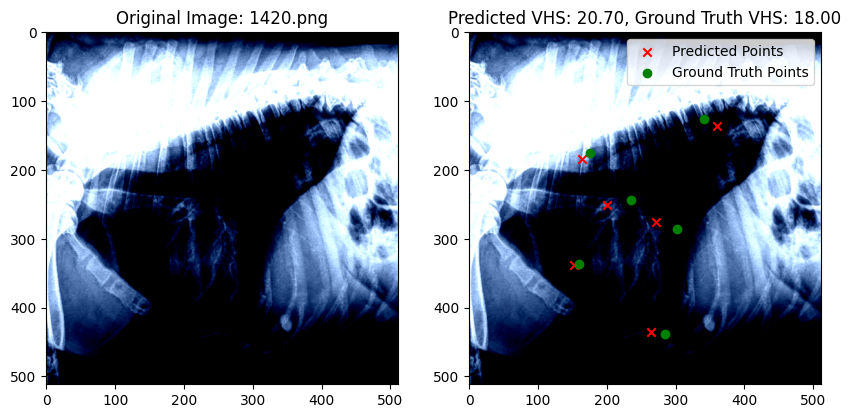

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4131124].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4131124].


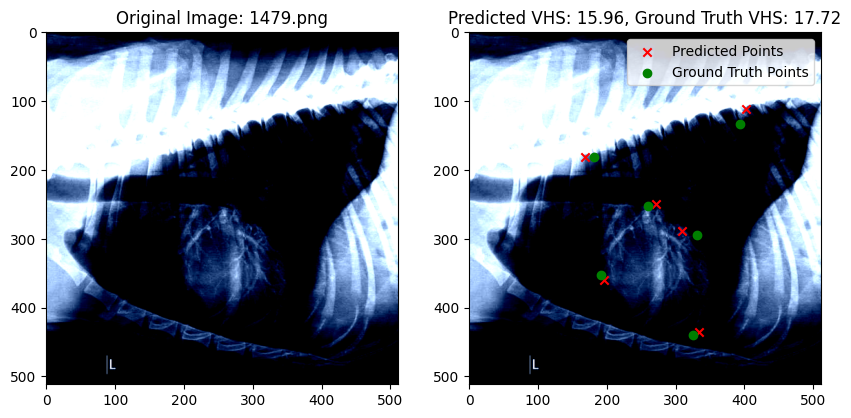

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0793803..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0793803..2.64].


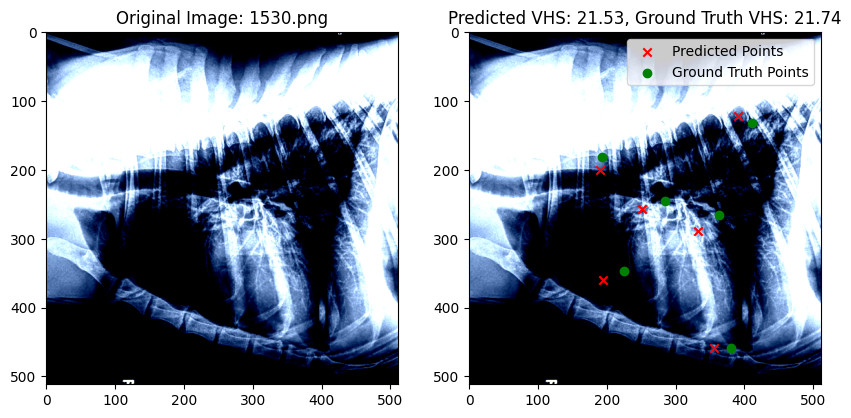

In [12]:
# Load validation dataset
val_dataset = DogHeartDataset('./Dog_data/Valid', get_transform(resized_image_size))
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Extract ground truth for specified images
ground_truth_dict = {}
for idx in range(len(val_dataset)):
    img, points, vhs = val_dataset[idx]
    img_name = val_dataset.imgs[idx]
    ground_truth_dict[img_name] = (img, points.numpy(), vhs.item())

# Specify the images to compare
specified_images = ['1420.png', '1479.png', '1530.png']

# Predict points on specified images from validation dataset
for specified_image in specified_images:
    if specified_image in ground_truth_dict:
        img, ground_truth_points, _ = ground_truth_dict[specified_image]

        # Predict points using the model
        img_tensor = img.to(device)
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0))
            predicted_points = output[0].cpu().numpy()

        # Plot ground truth and predicted points with lines connecting them
        plot_comparison(img, predicted_points, ground_truth_points, compute_vhs(predicted_points), compute_vhs(ground_truth_points), specified_image)
    else:
        print(f"Image {specified_image} not found in validation dataset")


## Load the Model and Generate Predictions

Load the saved model, make predictions on the test dataset, and generate a CSV file with the predicted VHS values.


In [13]:
import pandas as pd
# Function to load test dataset
def load_test_dataset(test_images_path, transform):
    test_imgs = list(sorted(os.listdir(test_images_path)))
    test_data = []
    for img_name in test_imgs:
        img_path = os.path.join(test_images_path, img_name)
        img = Image.open(img_path).convert("RGB")
        if transform is not None:
            img = transform(img)
        test_data.append((img, img_name))
    return test_data

# Parameters
resized_image_size = 512
num_keypoints = 6

# Load the model
model = KeypointDetectionModel(num_keypoints)
model_load_path = 'trained_model_bharat.pth'
model.load_state_dict(torch.load(model_load_path))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Load test dataset
test_images_path = './Dog_data/Images'
test_data = load_test_dataset(test_images_path, get_transform(resized_image_size))

# Predict points on test images and generate CSV file
test_results = []

model.eval()
with torch.no_grad():
    for img, img_name in test_data:
        img = img.to(device)

        # Forward pass
        output = model(img.unsqueeze(0))
        predicted_points = output[0].cpu().numpy()
        predicted_vhs = compute_vhs(predicted_points).item()

        test_results.append((img_name, predicted_vhs))

# Create a DataFrame and save to CSV
results_df = pd.DataFrame(test_results, columns=['image_name', 'predicted_VHS'])
csv_save_path = 'test_predictions_bharat.csv'
results_df.to_csv(csv_save_path, index=False)
print(f"CSV file with predictions saved to {csv_save_path}")

/anaconda/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_22247/1101559497.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-

CSV file with predictions saved to test_predictions_bharat.csv


### Software Accuracy

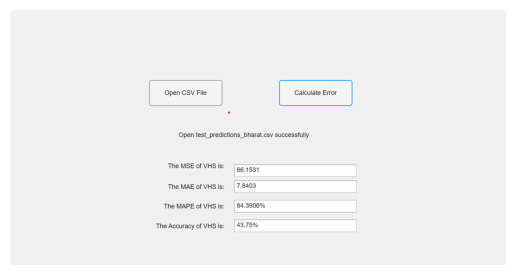

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# Open an image file
image_path = 'bharat_accuracy.png'
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()


### Link to paper

### https://www.researchgate.net/publication/382889694_CNN-Based_Detection_of_Canine_Vertebral_Heart_Size_in_X-rays